# Импорт библиотек

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

warnings.filterwarnings('ignore')

# Описание задачи

## О соревновании

https://ods.ai/competitions/mtsmlcup

Задача соревнования
- Определение пола и возраста владельца HTTP cookie по истории активности пользователя в интернете на основе синтетических данных.

Метрики соревнования:
* ROC-AUC – для определения пола, f1 weighted – для определения возраста.
* Все решения рассчитываются по формуле -  2 * f1_weighted(по 6 возрастным бакетам) + gini по полу.
* Возрастные бакеты (Класс 1 — 19-25, Класс 2 — 26-35, Класс 3 — 36-45, Класс 4 — 46-55, Класс 5 — 56-65, Класс 6 — 66+).

Предобработка, аггрегация и создание новых фич произведена в 0.Data_preparing.ipng.
Описание колонок аггрегированного файла с данными:
* 'part_of_day_day' – кол-во визитов пользователя днем
* 'part_of_day_evening' – кол-во визитов пользователя вечером
* 'part_of_day_morning' – кол-во визитов пользователя утром
* 'part_of_day_night' – кол-во визитов пользователя ночью
* 'sum_visits' – кол-во визитов пользователя
* 'day_pct' – доля визитов пользователя днем
* 'evening_pct' – доля визитов пользователя вечером
* 'morning_pct' – доля визитов пользователя утром
* 'night_pct' – доля визитов пользователя ночью
* 'act_days' – кол-во дней, в которые пользователь совершил визит пользователя
* 'request_cnt' - кол-во запросов пользователя
* 'avg_req_per_day' - среднее кол-во запросов пользователя
* 'period_days' - кол-во дней между первым и последним визитом пользователя
* 'request_std' - стандартное отклонение по количеству запросов
* 'act_days_pct' - доля дней, когда пользователь совершал визит
* 'cpe_type_cd - тип устройства
* 'cpe_model_os_type' - операционная система устройства
* 'cpe_manufacturer_name' -производитель устройства
* 'price' - цена устройства пользователя
* 'region_cnt' - кол-во уникальных регионов, из которых был совершен визит
* 'city_cnt' - кол-во уникальных городов, из которых был совершен визит
* 'url_host_cnt' - кол-во уникальных ссылок, с которых был совершен визит
* 'user_id' – ID пользователя

Описание колонок файла с таргетами:

* 'age' – Возраст пользователя
* 'is_male' – Признак пользователя : мужчина (1-Да, 0-Нет)
* 'user_id' – ID пользователя

## Структура проекта

Данная работа была разделена на несколько jupyter ноутбуков:

0. Data_preparing.ipnb - аггрегация отдельных файлов по user_id и склейка в финальный датасет
1. EDA.ipynb - исследовательская часть
2. baseline.ipynb - бейзлайн модели
3. create_embeddings.ipynb - создание эмбеддингов для дальнейшего их использования в качестве фич
4. baseline_embeddings.ipynb - бейзлан модели с эмбеддингами
5. model_tuning.ipynb - тюнинг наиболее перспективных моделей
6. gender_prediction_stacking.ipynb - стекинг моделей для предсказания пола

**В данном jypyter-ноутбуке мы проведем исследовательский анализ ранее сгруппированных нами данных и таргетов**

In [2]:
def barplot_group(df: pd.DataFrame, col_main: str, col_group: str,
                  title: str) -> None:
    """
    Построение barplot с нормированными данными с выводом значений на графике
    """

    plt.figure(figsize=(18, 6))

    data = (df.groupby(
        [col_group])[col_main].value_counts(normalize=True).rename(
            'percentage').mul(100).reset_index().sort_values(col_group))

    ax = sns.barplot(x=col_main,
                     y="percentage",
                     hue=col_group,
                     data=data,
                     palette='rocket')

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
            ha='center',  # центрирование
            va='center',
            xytext=(0, 7),
            textcoords='offset points',  # точка смещения относительно координаты
            fontsize=12)

    plt.title(title, fontsize=16)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)
    plt.show()

In [13]:
# типы колонок для экономии памяти
dict_types = {
    'user_id': 'int32',
    'part_of_day_day': 'int16',
    'part_of_day_evening': 'int16',
    'part_of_day_morning': 'int16',
    'part_of_day_night': 'int16',
    'sum_visits': 'int16',
    'day_pct': 'float32',
    'evening_pct': 'float32',
    'morning_pct': 'float32',
    'night_pct': 'float32',
    'act_days': 'int16',
    'request_cnt': 'int32',
    'avg_req_per_day': 'float32',
    'period_days': 'int16',
    'requests_std': 'float32',
    'act_days_pct': 'float32',
    'cpe_type_cd': 'category',
    'cpe_model_os_type': 'category',
    'cpe_manufacturer_name': 'category',
    'price': 'float32',
    'region_cnt': 'int8',
    'city_cnt': 'int8',
    'url_host_cnt': 'int16',
}

# возрастные бакеты
age_bins = {
    0: '0-18',
    1: '19-25',
    2: '26-35',
    3: '36-45',
    4: '46-55',
    5: '56-65',
    6: '66+'
}

# Обработка данных

In [14]:
# аггрегированные нами данные
df = pd.read_csv('data_agg/df_final.csv')

In [15]:
df.head(3)

,user_id,part_of_day_day,part_of_day_evening,part_of_day_morning,part_of_day_night,sum_visits,day_pct,evening_pct,morning_pct,night_pct,...,period_days,requests_std,act_days_pct,cpe_type_cd,cpe_model_os_type,cpe_manufacturer_name,price,region_cnt,city_cnt,url_host_cnt
0,13,467,447,411,226,1551,0.301096,0.288201,0.264990,0.145712,...,116,1.618662,0.974138,smartphone,Android,BQ Devices Limited,-999.0,1,1,83
1,41,7,13,9,9,38,0.184211,0.342105,0.236842,0.236842,...,4,1.562360,1.000000,smartphone,Android,Xiaomi,12343.0,1,3,15
2,69,457,346,314,30,1147,0.398431,0.301656,0.273758,0.026155,...,60,1.331956,0.933333,smartphone,iOS,Apple,16657.0,1,1,91


In [16]:
df = df.astype(dict_types)

In [17]:
df.shape

(415317, 23)

In [21]:
df.iloc[:, 1:10].describe()

,part_of_day_day,part_of_day_evening,part_of_day_morning,part_of_day_night,sum_visits,day_pct,evening_pct,morning_pct,night_pct
count,415317.000000,415317.000000,415317.000000,415317.000000,415317.000000,415317.000000,415317.000000,415317.000000,415317.000000
mean,258.425249,231.724890,205.231221,82.095688,777.477048,0.359119,0.284321,0.267288,0.089272
std,338.331753,325.037188,285.364947,153.940339,1034.880997,0.161825,0.145989,0.147516,0.097320
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,26.000000,25.000000,3.000000,105.000000,0.275449,0.217695,0.191845,0.013798
50%,142.000000,117.000000,105.000000,25.000000,421.000000,0.337758,0.290323,0.260163,0.066944
75%,353.000000,312.000000,275.000000,94.000000,1055.000000,0.420213,0.349162,0.325855,0.135246
max,8853.000000,9140.000000,9312.000000,5568.000000,29596.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
df.iloc[:, 10:].describe()

,act_days,request_cnt,avg_req_per_day,period_days,requests_std,act_days_pct,price,region_cnt,city_cnt,url_host_cnt
count,415317.000000,415317.000000,415317.000000,415317.000000,415317.000000,415317.000000,415317.000000,415317.000000,415317.000000,415317.000000
mean,31.118577,1340.523297,37.338802,40.103641,0.974938,0.779834,27979.820312,1.786255,3.102782,77.718150
std,28.067159,1896.511893,32.229130,31.485918,0.407378,0.242793,24447.123047,1.633052,3.907550,70.130401
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.016667,-999.000000,1.000000,1.000000,1.000000
25%,8.000000,156.000000,14.000000,15.000000,0.727090,0.666667,11411.000000,1.000000,1.000000,28.000000
50%,24.000000,672.000000,28.913044,35.000000,0.986201,0.875000,18301.000000,1.000000,2.000000,60.000000
75%,46.000000,1776.000000,51.299999,58.000000,1.237035,0.960784,40515.000000,2.000000,4.000000,107.000000
max,181.000000,67356.000000,703.095215,181.000000,4.242640,1.000000,195657.000000,41.000000,124.000000,1642.000000


Признак price содержит минимальное значение -999, это заполненные нами пропуски при аггрегации данных. В остальных признаках никаких аномалий не наблюдается

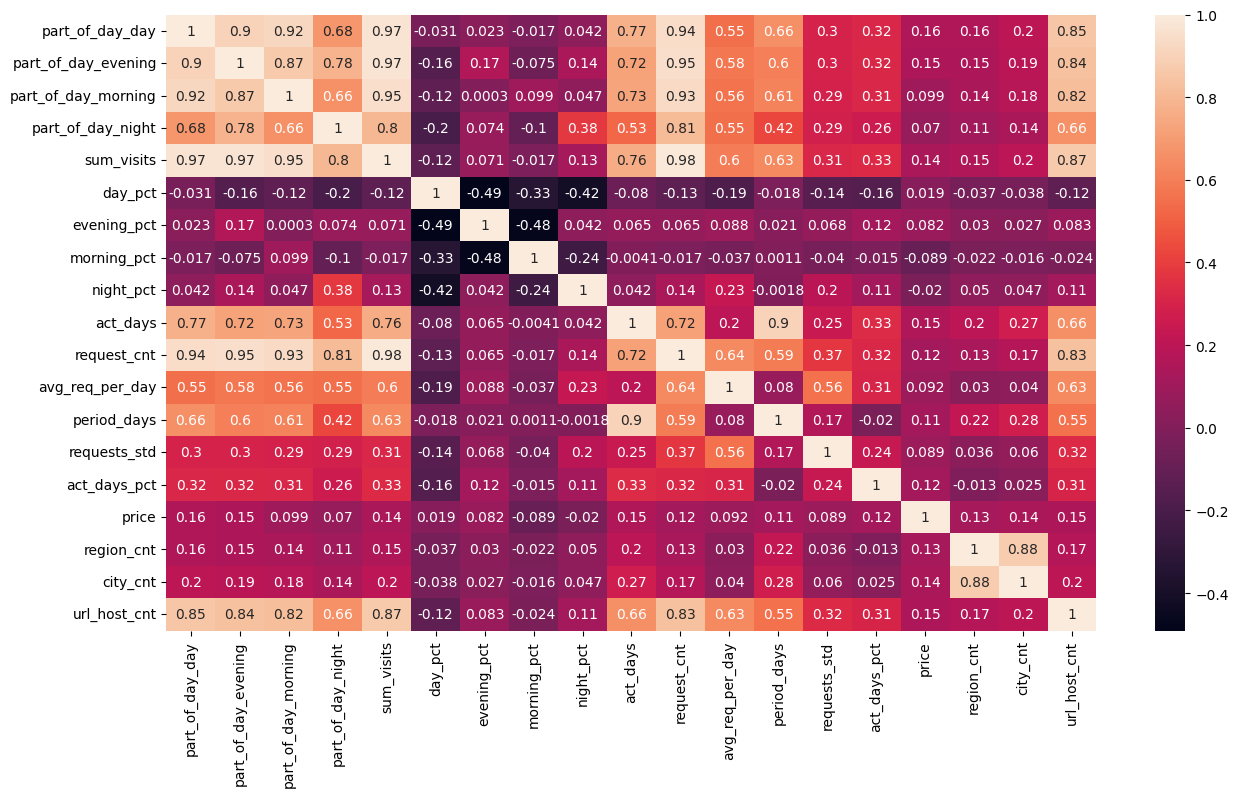

In [24]:
# посмотрим корреляцию между нашими признаками
plt.figure(figsize=(15, 8))
sns.heatmap(df.drop(['user_id'], axis=1).corr(), 
            annot=True);

In [25]:
# исключим сильно скоррелированные признаки
cor_matrix = df.drop(['user_id'], axis=1).corr().abs()

upper_tri = cor_matrix.where(
    np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))

to_drop = [
    column for column in upper_tri.columns if any(upper_tri[column] > 0.9)
]

df_clean = df.drop(to_drop, axis=1)

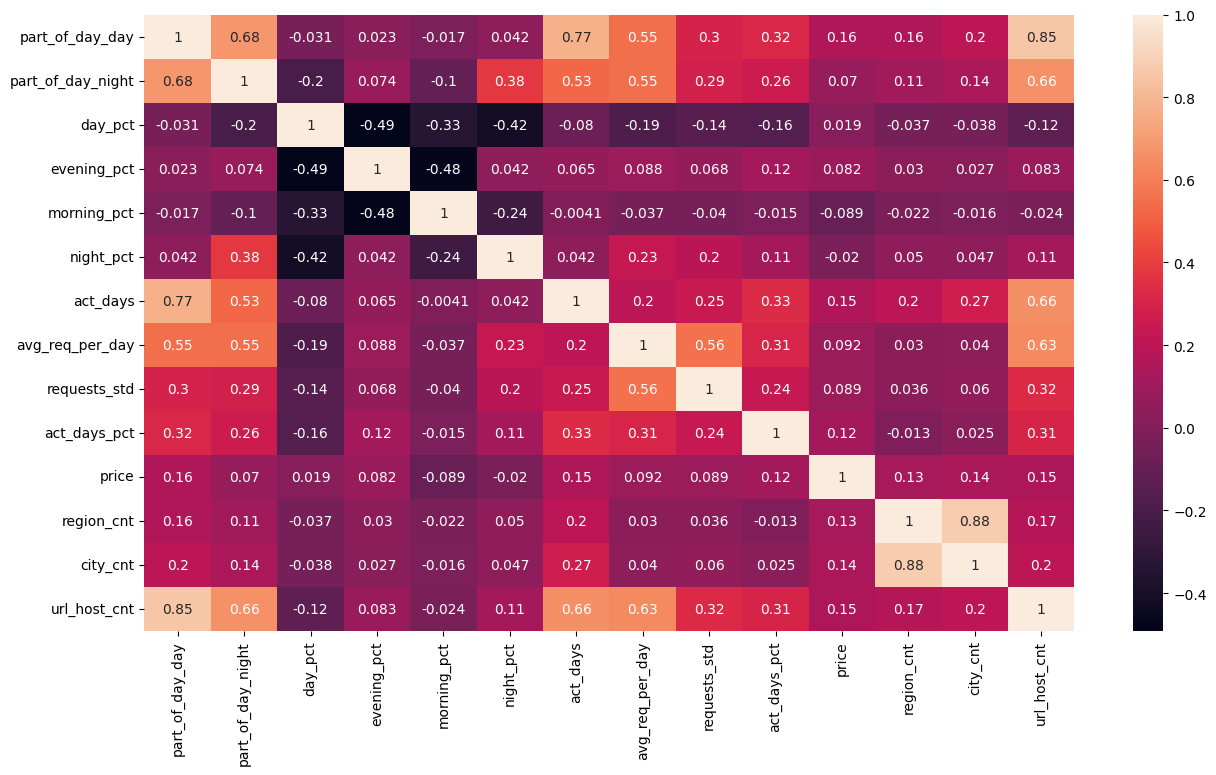

In [33]:
plt.figure(figsize=(15, 8))
sns.heatmap(df_clean.drop(['user_id'], axis=1).corr(), annot=True);

In [28]:
# данные с таргетами
public_train = pd.read_parquet('public_train.pqt')
public_train[:3]

,age,is_male,user_id
350459,31.0,1,350459
188276,35.0,1,188276
99002,41.0,0,99002


In [29]:
# создаем возрастные бакеты
public_train['age_bin'] = pd.cut(x=public_train['age'],
                                 bins=[-1, 18, 25, 35, 45, 55, 65, 120],
                                 labels=age_bins.values())

In [30]:
# соединяем признаки и таргеты
train_data = public_train.merge(df_clean, how='left', on='user_id')

In [32]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270000 entries, 0 to 269999
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   age                    269999 non-null  float64 
 1   is_male                269958 non-null  object  
 2   user_id                270000 non-null  int64   
 3   age_bin                269999 non-null  category
 4   part_of_day_day        270000 non-null  int16   
 5   part_of_day_night      270000 non-null  int16   
 6   day_pct                270000 non-null  float32 
 7   evening_pct            270000 non-null  float32 
 8   morning_pct            270000 non-null  float32 
 9   night_pct              270000 non-null  float32 
 10  act_days               270000 non-null  int16   
 11  avg_req_per_day        270000 non-null  float32 
 12  requests_std           270000 non-null  float32 
 13  act_days_pct           270000 non-null  float32 
 14  cpe_type_cd         

# Exploratory data analysis

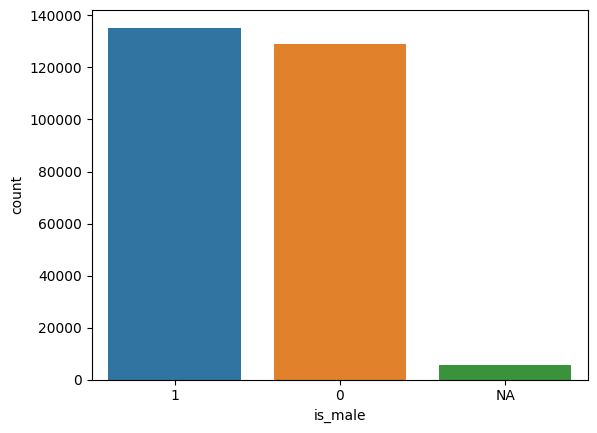

In [34]:
# рассмотрим соотношение полов в нашем датасете
sns.countplot(x=train_data['is_male']);

Соотношение мужчин и женщин близко, также есть небольшое количество пропусков

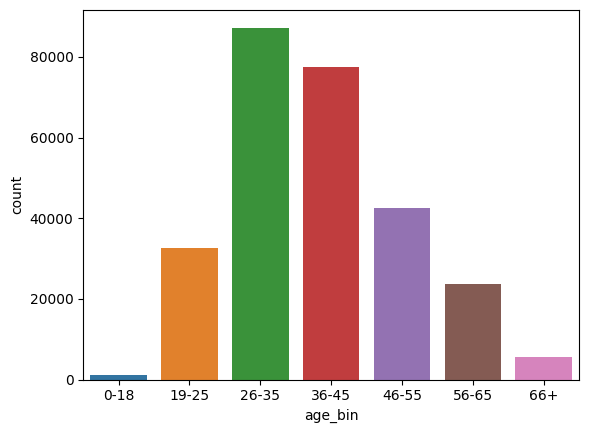

In [39]:
# рассмотрим соотношение возрастных бакетов в нашем датасете
sns.countplot(x=train_data['age_bin']);

Наибольшие доли пользователей в возрасте 26-35 и 36-45, наименьшие - в возрасте 0-18 и 66+

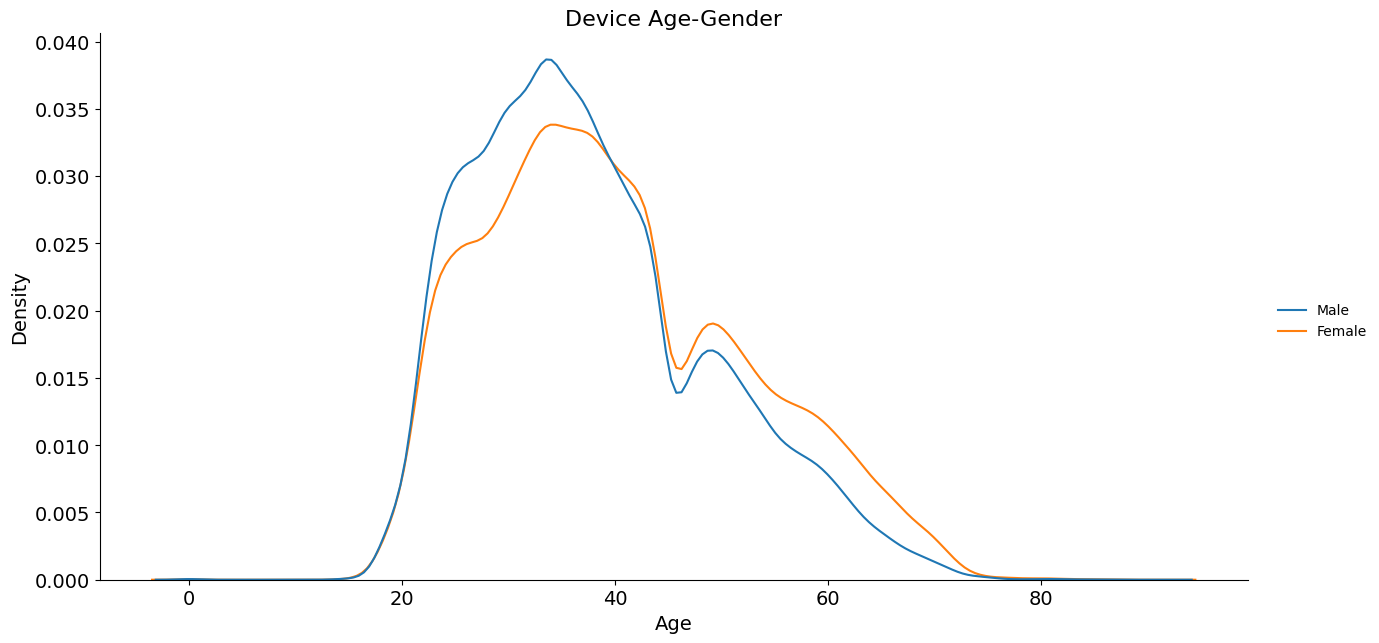

In [65]:
# рассмотрим распределение возрастов пользователей среди мужчин и женщин
sns.displot(
    {
        "Male": train_data[train_data['is_male'] == '1'].age,
        "Female": train_data[train_data['is_male'] == '0'].age,
    },
    kind="kde",
    common_norm=False,
    height=6,
    aspect=2.1)

plt.title('Device Age-Gender', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

В возрасте от 22 до 40 большинство соотношение в пользу мужчин, в возрасте от 45 до 75 в пользу женщин

## Gender

### Гипотеза 1
Соотношение между мужчинами и женщинами примерно одинаковое во всех возрастных бакетах

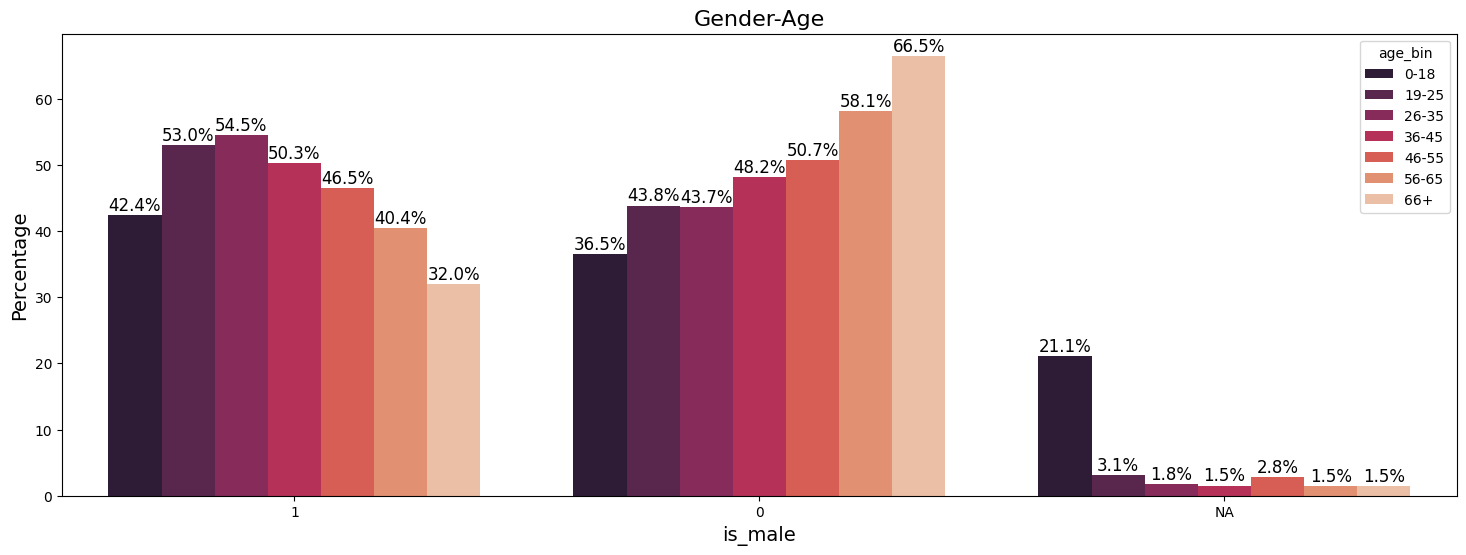

In [61]:
barplot_group(train_data, 'is_male', 'age_bin', 'Gender-Age')

Вывод: в возрасте от 0 до 45 лет в соотношении мужчин к женщинам есть небольшой перевес в пользу мужчин, от 46 до 66+ перевес в сторону женщин

### Гипотеза 2
Среди пользователей Android больше мужчин, среди пользователей iOS - женщин

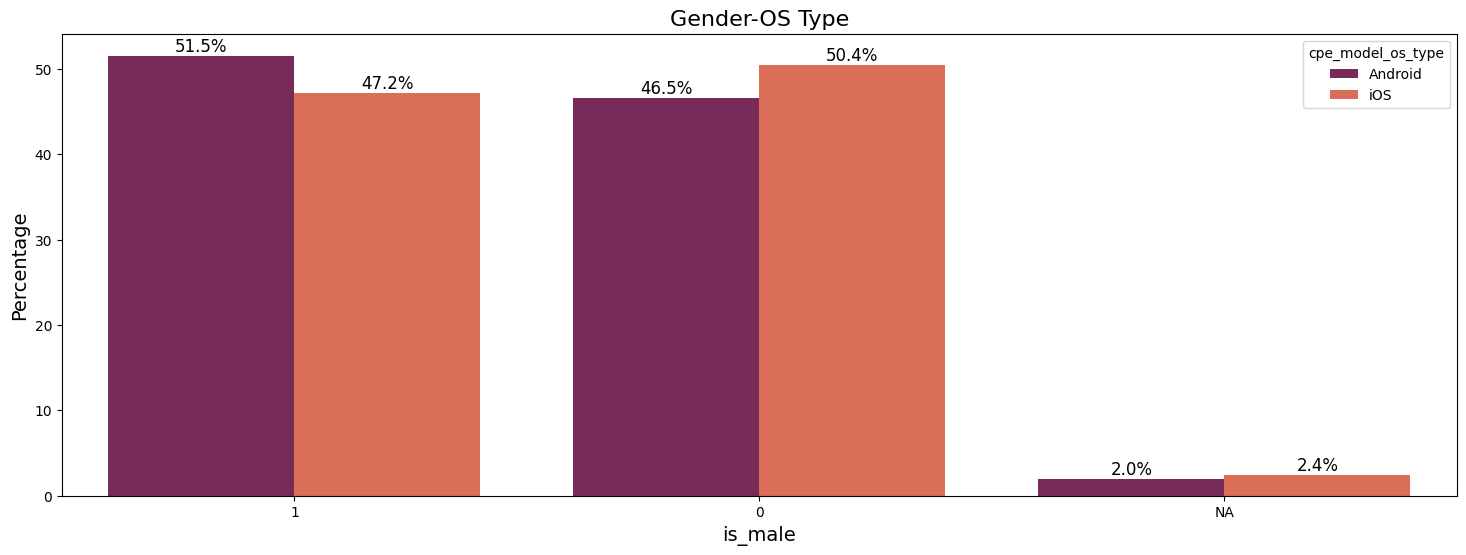

In [36]:
barplot_group(train_data, 'is_male', 'cpe_model_os_type', 'Gender-OS Type')

Вывод: среди пользователей Android небольшой перевес в соотношении в пользу мужчин, среди пользователей iOS - в пользу женщин

### Гипотеза 3
Среди пользователей смартфонов и планшетов больше женщин, в другие категориях наоборот

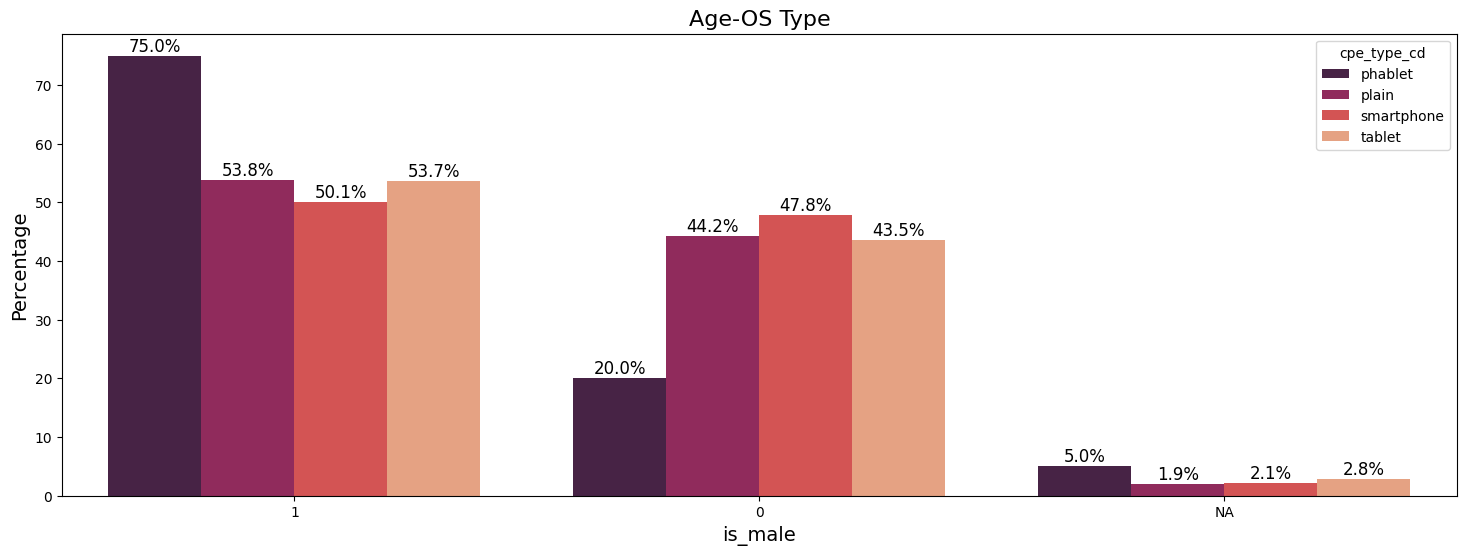

In [63]:
barplot_group(train_data, 'is_male', 'cpe_type_cd', 'Gender-Device type')

Вывод: 75% пользователей phablet - мужчины, в остальных категориях соотношение примерно равное

### Гипотеза 4
Женщины чаще покупают более дорогие телефоны

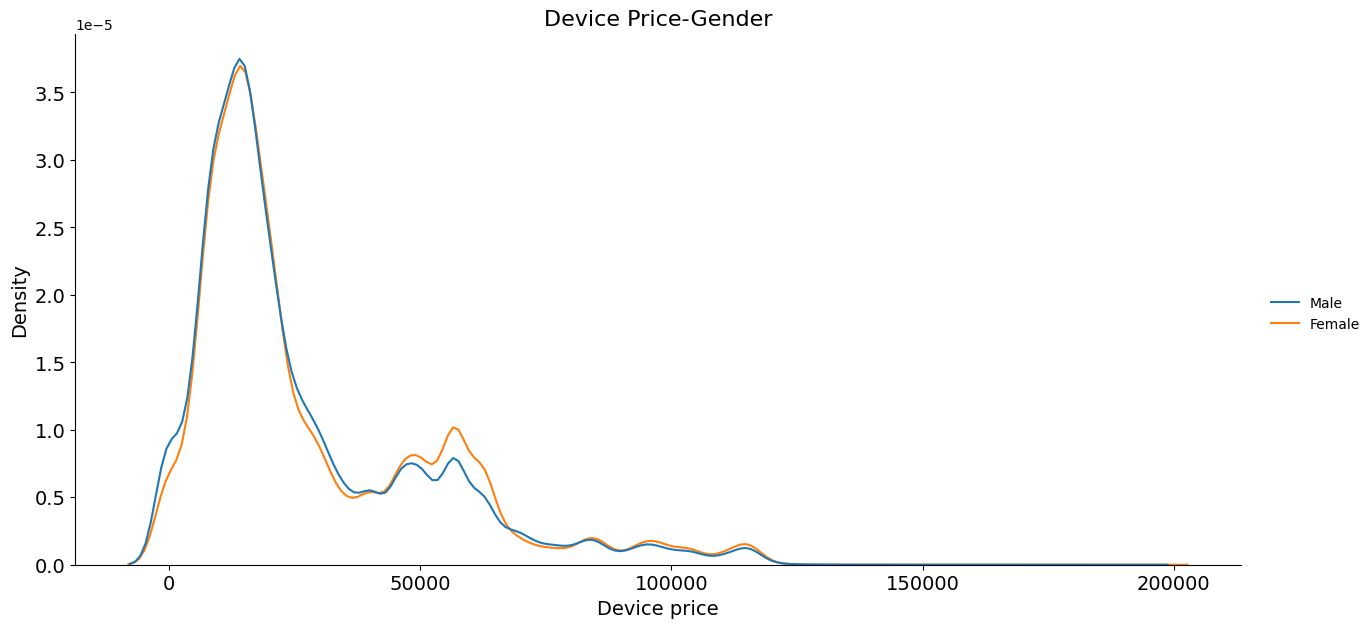

In [38]:
sns.displot(
    {
        "Male": train_data[train_data['is_male'] == '1'].price,
        "Female": train_data[train_data['is_male'] == '0'].price,
    },
    kind="kde",
    common_norm=False,
    height=6,
    aspect=2.1)

plt.title('Device Price-Gender', fontsize=16)
plt.xlabel('Device price', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Вывод: в диапазоне цены девайса 50-70 тысяч небольшой перевес в пользу женщин, в остальном распределения очень похожи

### Гипотеза 5
Доля заходов в первую половину суток у женщин выше, доля во вторую половину выше у мужчин.

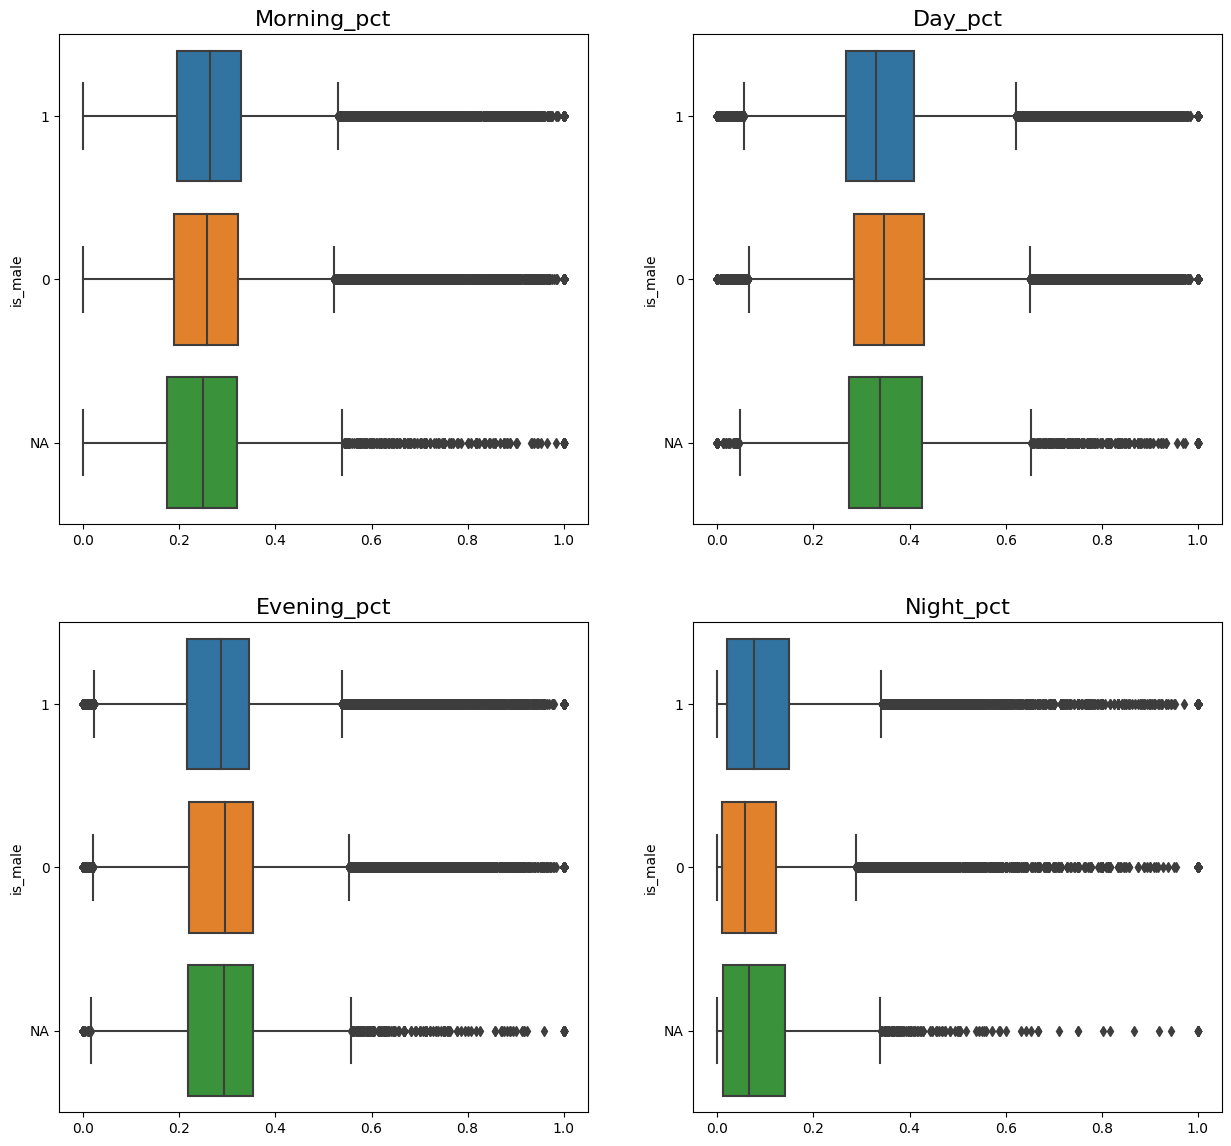

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 14))

graph1 = sns.boxplot(data=train_data,
                     x='morning_pct',
                     y='is_male',
                     ax=axes[0, 0])
axes[0, 0].set_title('Morning_pct', fontsize=16)
graph1.set(xlabel=None)

graph2 = sns.boxplot(data=train_data, x='day_pct', y='is_male', ax=axes[0, 1])
axes[0, 1].set_title('Day_pct', fontsize=16)
graph2.set(xlabel=None)

graph3 = sns.boxplot(data=train_data,
                     x='evening_pct',
                     y='is_male',
                     ax=axes[1, 0])
axes[1, 0].set_title('Evening_pct', fontsize=16)
graph3.set(xlabel=None)

graph4 = sns.boxplot(data=train_data,
                     x='night_pct',
                     y='is_male',
                     ax=axes[1, 1])
axes[1, 1].set_title('Night_pct', fontsize=16)
graph4.set(xlabel=None)

plt.show()

Вывод: медианные значения доли заходов утром и ночью выше у мужчин, днем и вечером - у женщин

### Гипотеза 6
Мужчины чаще ездят по регионам и городам

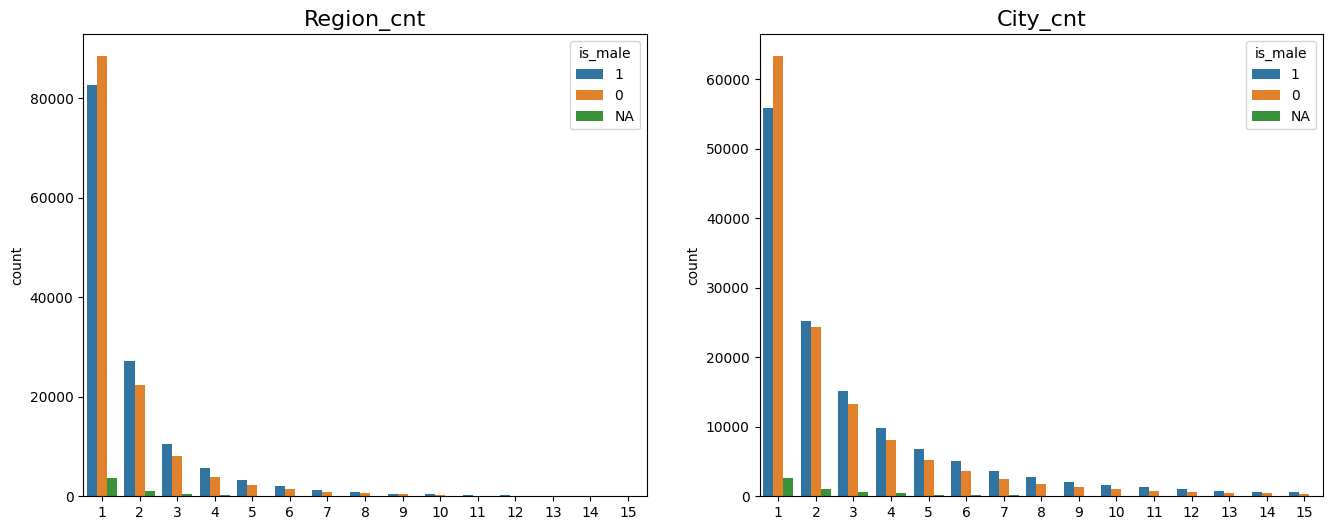

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

graph1 = sns.countplot(data=train_data.query('region_cnt <= 15'),
                       x='region_cnt',
                       hue='is_male',
                       ax=axes[0])
axes[0].set_title('Region_cnt', fontsize=16)
graph1.set(xlabel=None)

graph2 = sns.countplot(data=train_data.query('city_cnt <= 15'),
                       x='city_cnt',
                       hue='is_male',
                       ax=axes[1])
axes[1].set_title('City_cnt', fontsize=16)
graph2.set(xlabel=None)

plt.show()

Вывод: женщины чаще мужчин отправляют запросы только из 1 региона и города, в остальных случаях перевес в пользу мужчин

### Гипотеза 7
Женщины отправляют в среднем больше запросов в день, чем мужчины

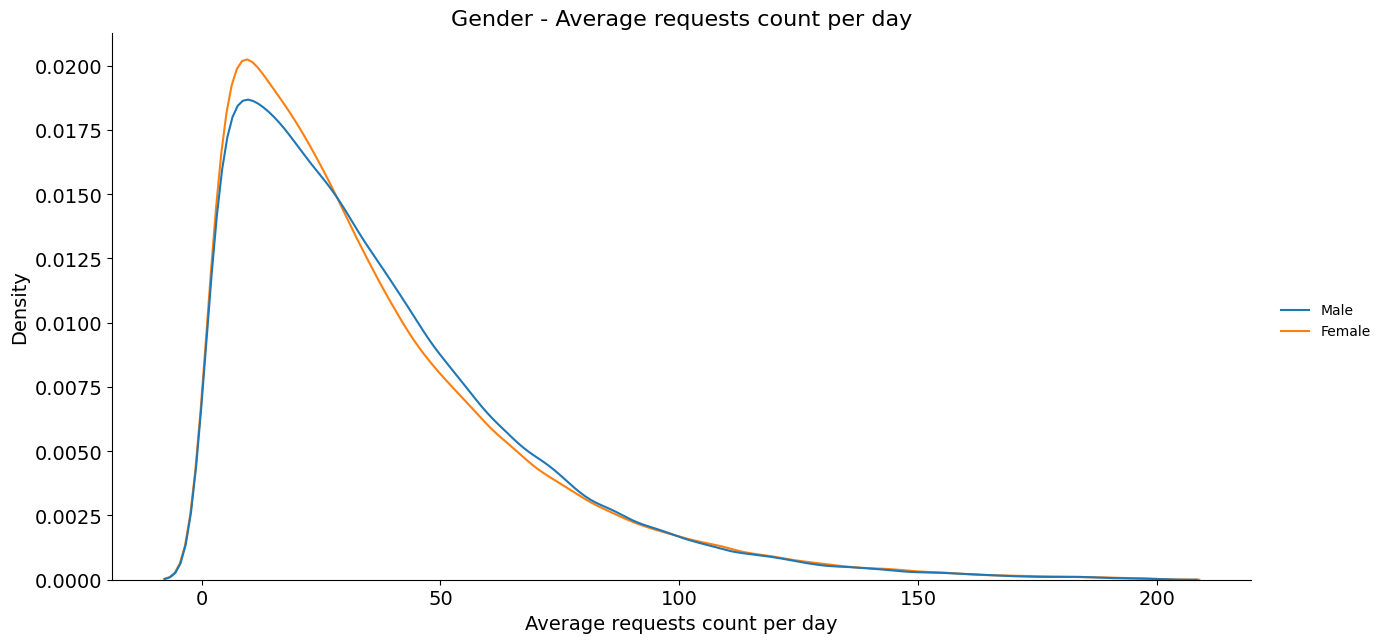

In [77]:
sns.displot(
    {
        "Male":
        train_data.query(
            'avg_req_per_day < 200 and is_male == "1"').avg_req_per_day,
        "Female":
        train_data.query(
            'avg_req_per_day < 200 and is_male == "0"').avg_req_per_day,
    },
    kind="kde",
    common_norm=False,
    height=6,
    aspect=2.1)

plt.title('Gender - Average requests count per day', fontsize=16)
plt.xlabel('Average requests count per day', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Вывод: среди людей, которые отправляют запросы до 35 раз в день больше женщин, среди тех, кто больше 35 - больше мужчин

### Гипотеза 8
Женщины совершают визиты на большее число сайтов

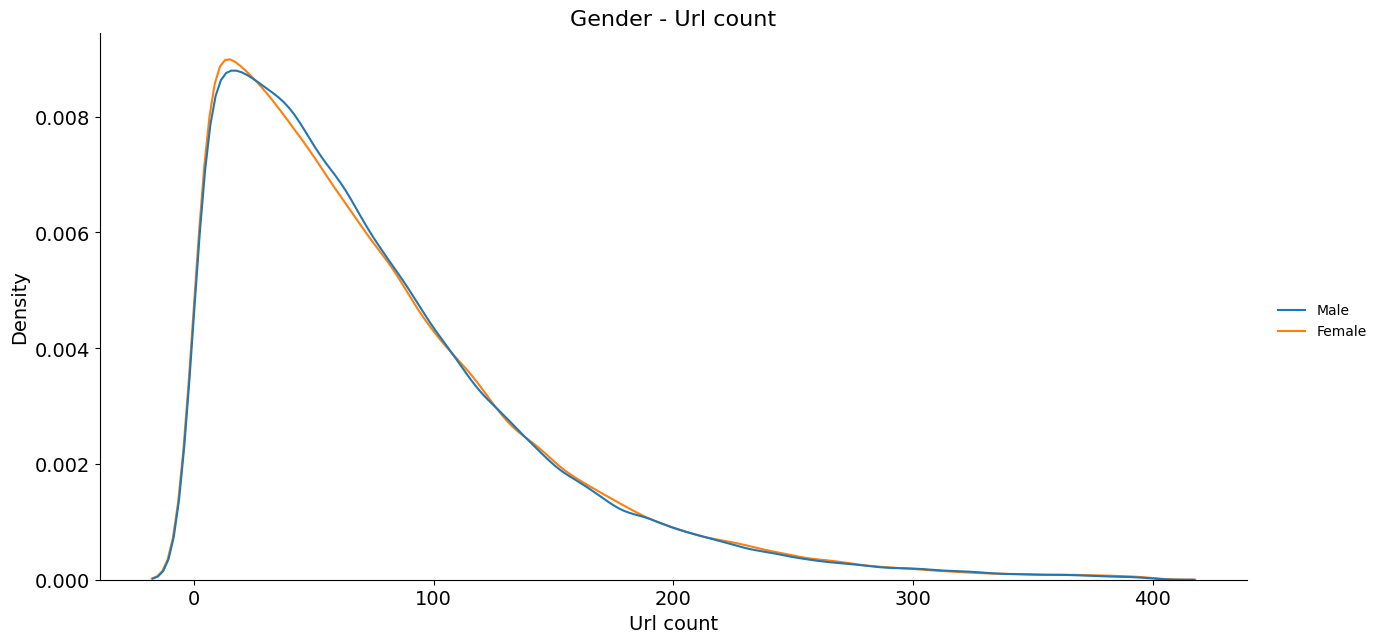

In [87]:
sns.displot(
    {
        "Male":
        train_data.query('url_host_cnt < 400 and is_male == "1"').url_host_cnt,
        "Female":
        train_data.query('url_host_cnt < 400 and is_male == "0"').url_host_cnt,
    },
    kind="kde",
    common_norm=False,
    height=6,
    aspect=2.1)

plt.title('Gender - Url count', fontsize=16)
plt.xlabel('Url count', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Вывод: разницы в распределения почти нет, у женщин чуть чаще встречается кол-во сайтов до 50, у мужчин чуть чаще с 50 до 90

### Гипотеза 9
Процент активных дней у женщин выше

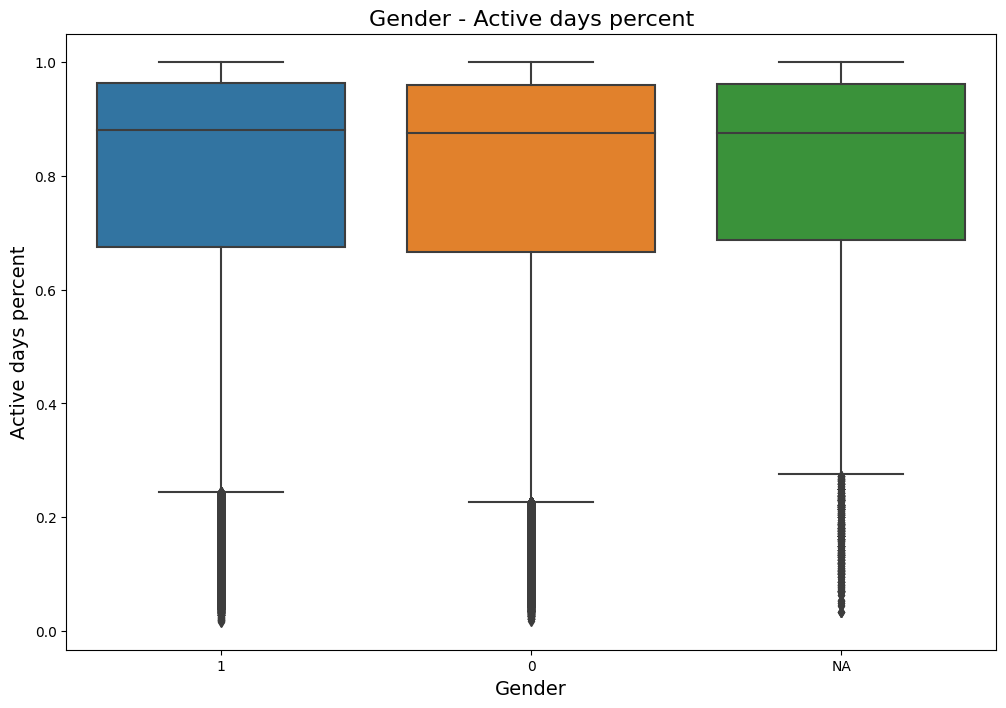

In [93]:
plt.figure(figsize=(12, 8))

sns.boxplot(data=train_data, x='is_male', y='act_days_pct')

plt.title('Gender - Active days percent', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Active days percent', fontsize=14)

Вывод: разница между медианными значениями процента активных дней у мужчин и женщин минимальна

## Age

### Гипотеза 1
Молодые люди покупают себе более дорогие телефоны

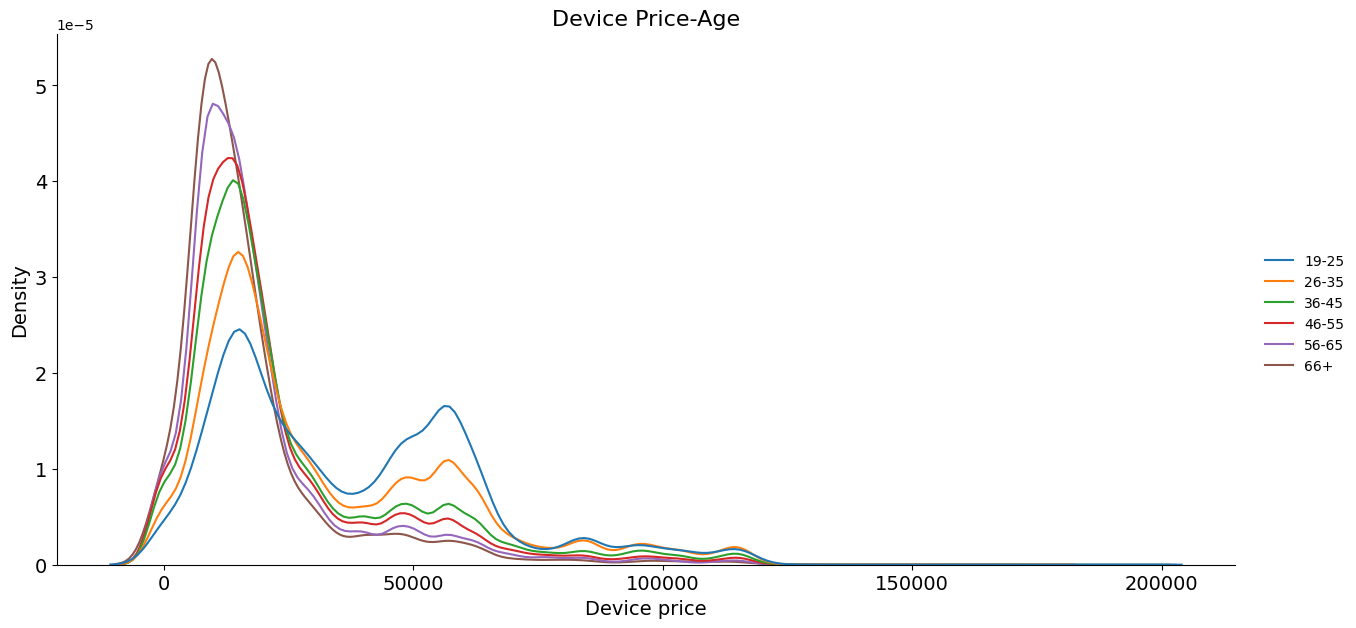

In [86]:
sns.displot(
    {
        "19-25": train_data[train_data['age_bin'] == '19-25'].price,
        "26-35": train_data[train_data['age_bin'] == '26-35'].price,
        "36-45": train_data[train_data['age_bin'] == '36-45'].price,
        "46-55": train_data[train_data['age_bin'] == '46-55'].price,
        "56-65": train_data[train_data['age_bin'] == '56-65'].price,
        "66+": train_data[train_data['age_bin'] == '66+'].price,
    },
    kind="kde",
    common_norm=False,
    height=6,
    aspect=2.1)

plt.title('Device Price-Age', fontsize=16)
plt.xlabel('Device price', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Вывод: наибольшая доля людей с телефонами до 20т.р. - люди 66+, наибольшая доля людей с телефонами от 40 до 70т.р. - люди от 19 до 25 лет. Чем старше человек, тем дешевле у него телефон

### Гипотеза 2
Аудитория iOS моложе, чем аудитория Android

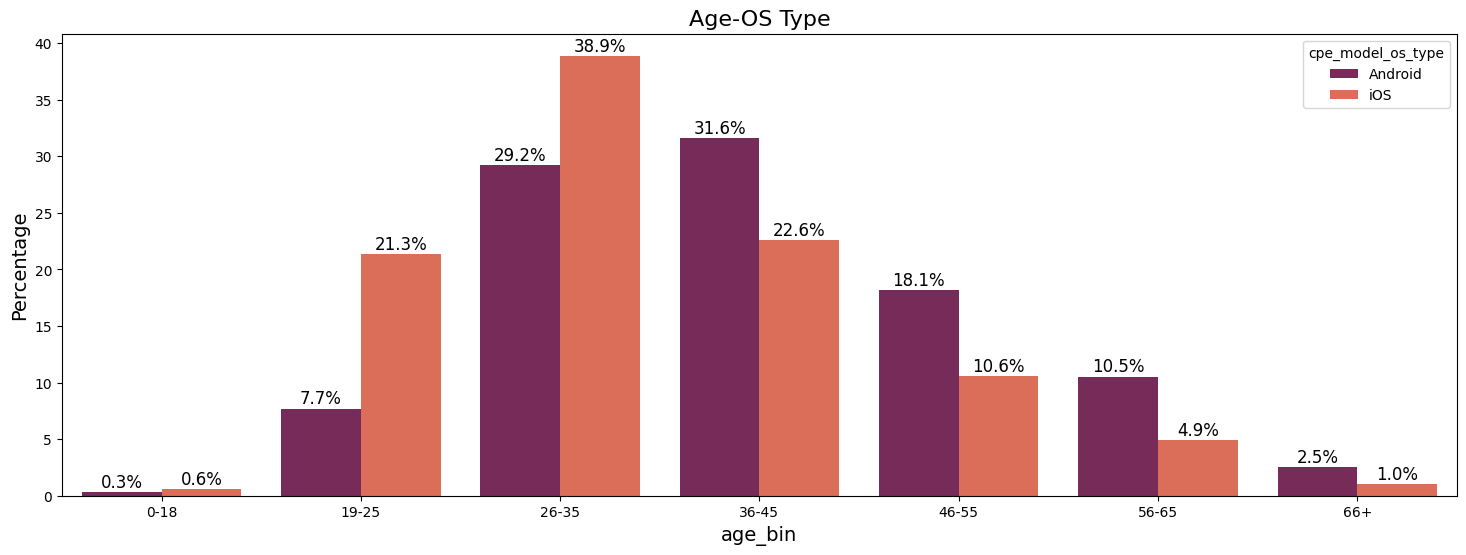

In [81]:
barplot_group(train_data, 'age_bin', 'cpe_model_os_type', 'Age-OS Type')

Вывод: по распределению пользователей по операционным системам видно, что пользователи iOS чуть моложе - самая большая часть пользователей в категории 26-35, у Android - 36-45

### Гипотеза 3
Чем старше категория, тем больше доля Android

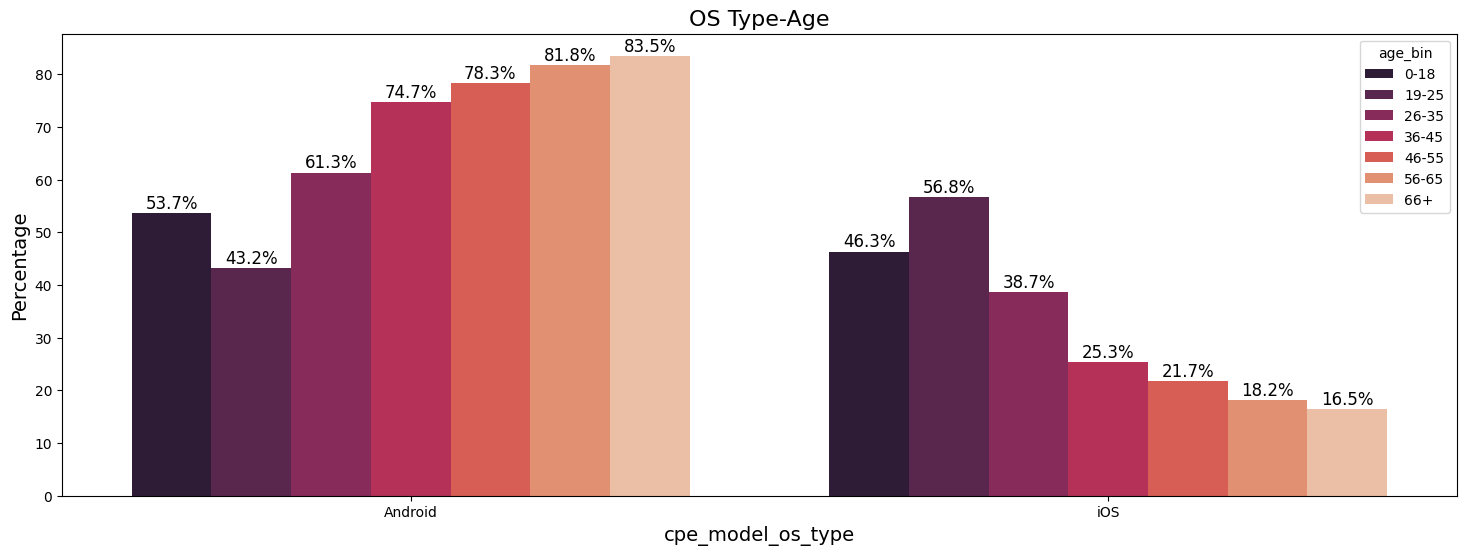

In [82]:
barplot_group(train_data, 'cpe_model_os_type', 'age_bin', 'OS Type-Age')

Вывод: соотношение пользователей в группе 19-25 в пользу iOS, в остальных группах намного чаще пользователи выбирают Android

### Гипотеза 4
Чем моложе человек, тем больше запросов в день он делает

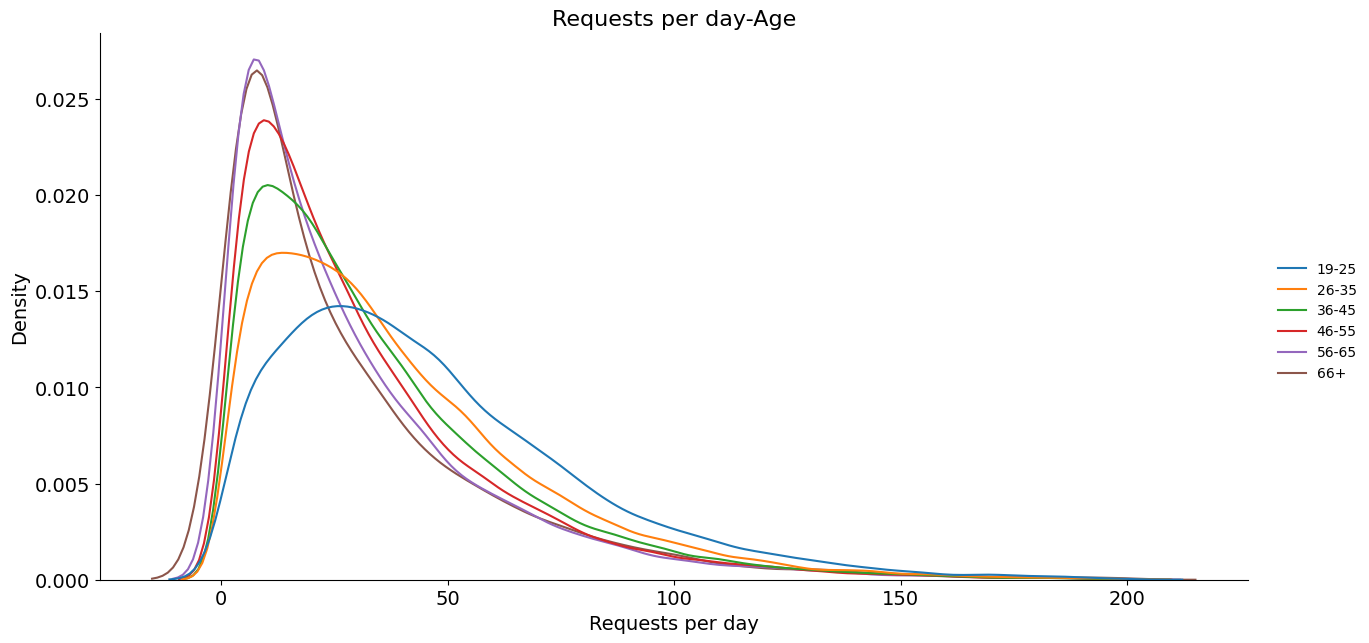

In [96]:
sns.displot(
    {
        "19-25":
        train_data.query(
            'avg_req_per_day < 200 and age_bin == "19-25"').avg_req_per_day,
        "26-35":
        train_data.query(
            'avg_req_per_day < 200 and age_bin == "26-35"').avg_req_per_day,
        "36-45":
        train_data.query(
            'avg_req_per_day < 200 and age_bin == "36-45"').avg_req_per_day,
        "46-55":
        train_data.query(
            'avg_req_per_day < 200 and age_bin == "46-55"').avg_req_per_day,
        "56-65":
        train_data.query(
            'avg_req_per_day < 200 and age_bin == "56-65"').avg_req_per_day,
        "66+":
        train_data.query(
            'avg_req_per_day < 200 and age_bin == "66+"').avg_req_per_day,
    },
    kind="kde",
    common_norm=False,
    height=6,
    aspect=2.1)

plt.title('Requests per day-Age', fontsize=16)
plt.xlabel('Requests per day', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Вывод: с увеличением возраста люди делают меньше запросов. До 20 запросов в день делают люди из категории 66+, от 45 до 150 запросов чаще всего делают люди из категории 19-25

### Гипотеза 5
Доля запросов утром и ночью больше у более молодых людей

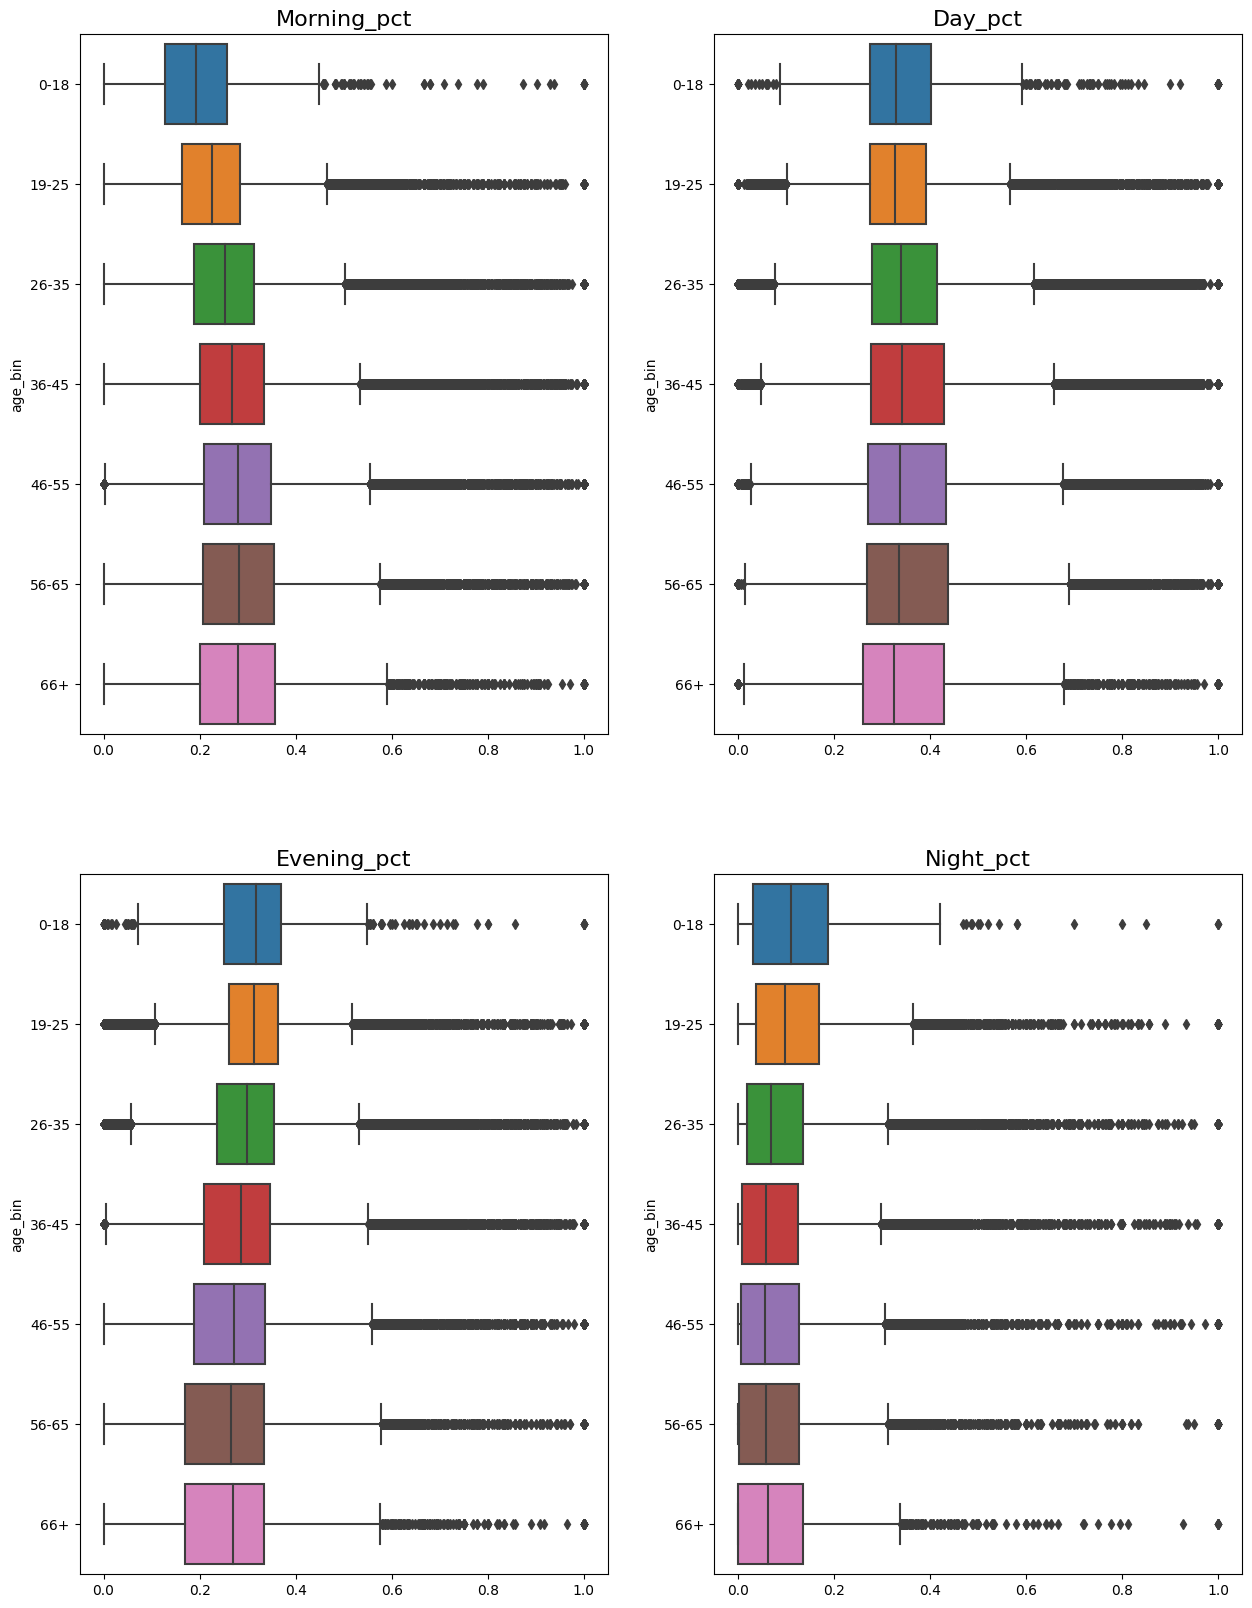

In [97]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 20))

graph1 = sns.boxplot(data=train_data,
                     x='morning_pct',
                     y='age_bin',
                     ax=axes[0, 0])
axes[0, 0].set_title('Morning_pct', fontsize=16)
graph1.set(xlabel=None)

graph2 = sns.boxplot(data=train_data, x='day_pct', y='age_bin', ax=axes[0, 1])
axes[0, 1].set_title('Day_pct', fontsize=16)
graph2.set(xlabel=None)

graph3 = sns.boxplot(data=train_data,
                     x='evening_pct',
                     y='age_bin',
                     ax=axes[1, 0])
axes[1, 0].set_title('Evening_pct', fontsize=16)
graph3.set(xlabel=None)

graph4 = sns.boxplot(data=train_data,
                     x='night_pct',
                     y='age_bin',
                     ax=axes[1, 1])
axes[1, 1].set_title('Night_pct', fontsize=16)
graph4.set(xlabel=None)

plt.show()

Вывод: чем старше человек, тем выше медианный процент запросов утром. Днем примерно одинаковый процент запросов среди категорий. Вечером и ночью более молодые люди делают больший процент запросов

### Гипотеза 6
Чем старше человек, тем меньше у него активных дней

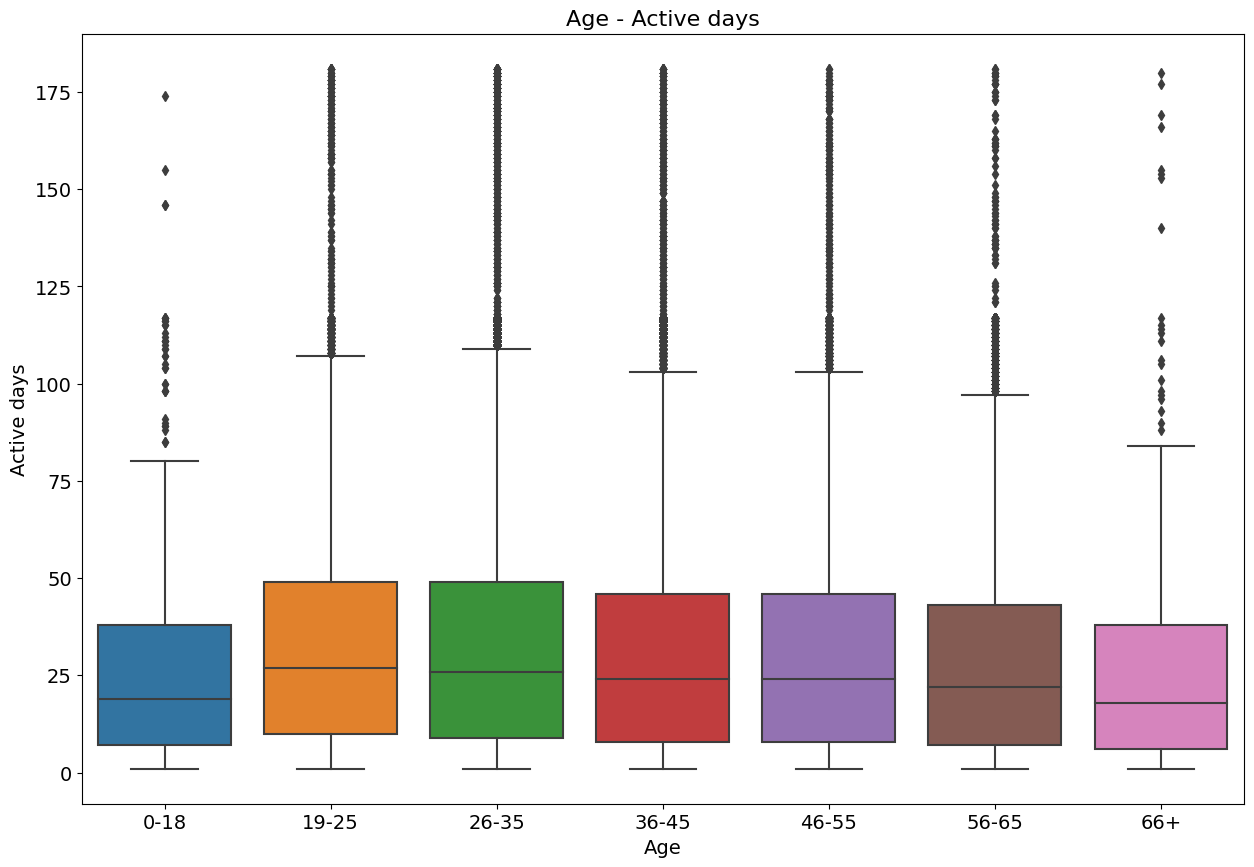

In [111]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=train_data, x='age_bin', y='act_days')

plt.title('Age - Active days', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Active days', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Вывод: чем старше человек, тем меньше у него активных дней

### Гипотеза 7
Чем моложе человек, тем больше с большего кол-ва сайтов он совершал переходы

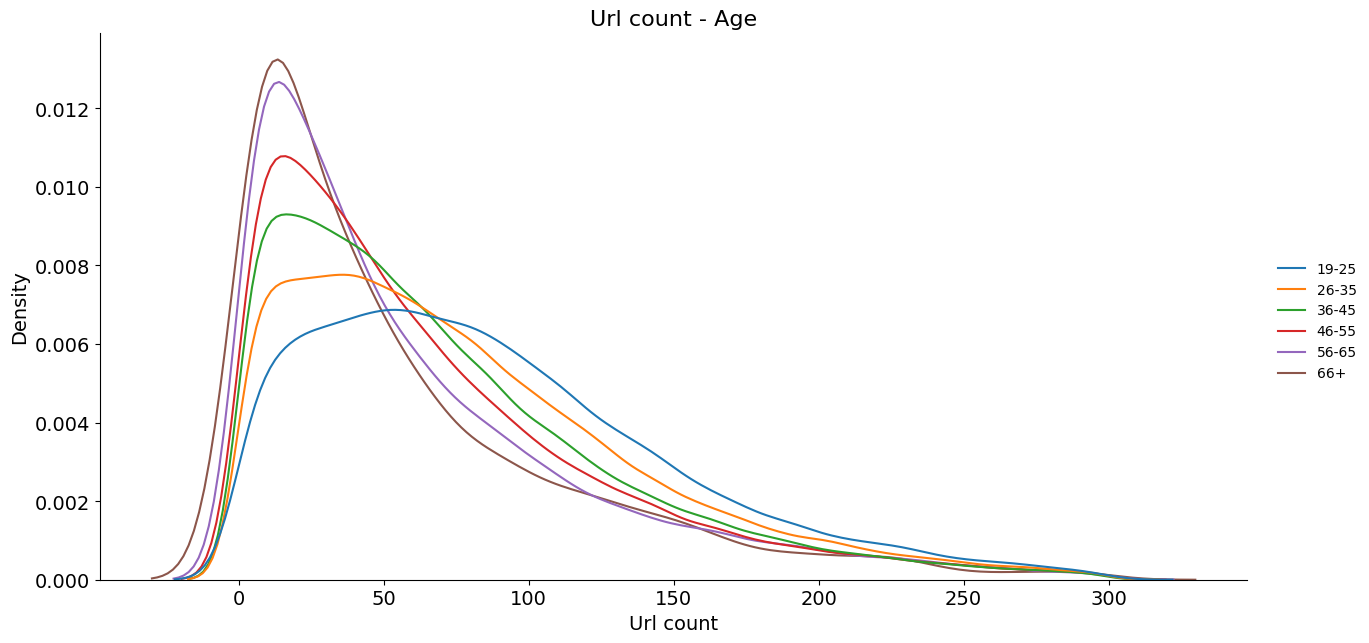

In [114]:
sns.displot(
    {
        "19-25":
        train_data.query(
            'url_host_cnt < 300 and age_bin == "19-25"').url_host_cnt,
        "26-35":
        train_data.query(
            'url_host_cnt < 300 and age_bin == "26-35"').url_host_cnt,
        "36-45":
        train_data.query(
            'url_host_cnt < 300 and age_bin == "36-45"').url_host_cnt,
        "46-55":
        train_data.query(
            'url_host_cnt < 300 and age_bin == "46-55"').url_host_cnt,
        "56-65":
        train_data.query(
            'url_host_cnt < 300 and age_bin == "56-65"').url_host_cnt,
        "66+":
        train_data.query(
            'url_host_cnt < 300 and age_bin == "66+"').url_host_cnt,
    },
    kind="kde",
    common_norm=False,
    height=6,
    aspect=2.1)

plt.title('Url count - Age', fontsize=16)
plt.xlabel('Url count', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Вывод: наибольшая доля людей с количеством посещенных сайтов до 40 из категории 66+, наибольшая доля людей с количеством посещенных сайтов от 80 из категории 19-25. Молодые люди посещают больше сайтов, чем более взрослые люди

### Гипотеза 8
Чем моложе человек, тем больше городов, из которых он отправляет запросы

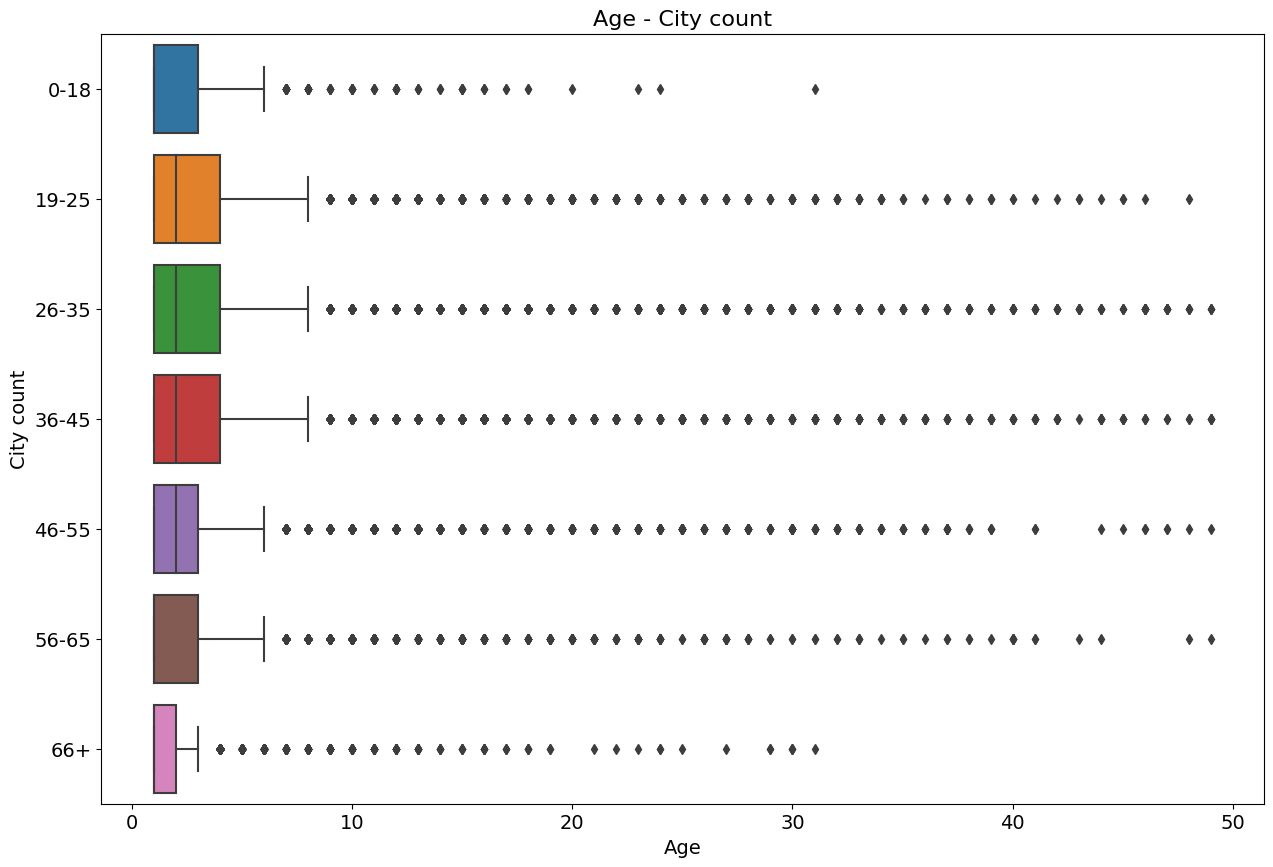

In [120]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=train_data.query('city_cnt < 50'), 
            x='city_cnt', 
            y='age_bin')

plt.title('Age - City count', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('City count', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Вывод: медианное значение количества городов в разных категориях не отличается